# RSNA PyTorch Hackathon FasterRCNN ResNet

## Resources
* [rsna-pneumonia-detection-2018](https://www.kaggle.com/sovitrath/rsna-pneumonia-detection-2018)

In [ ]:
%%capture
!pip install albumentations==0.4.6

!pip install kaggle # Install the Kaggle library
!mkdir ~/.kaggle  # Make a directory named “.kaggle”
!cp kaggle.json ~/.kaggle/  # Copy the “kaggle.json” into this new directory
!chmod 600 ~/.kaggle/kaggle.json  # Allocate the required permission for this file.

## Import Libraries

In [ ]:
#%%writefile test.py
import sys
import os
import pandas as pd
import numpy as np
import cv2
import os
import re
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
from tqdm import tqdm

plt.style.use('grayscale')

## Download Image Files 

In [ ]:
# %%capture

#!gdown https://drive.google.com/uc?id=1dU40tFicl3913iPWrVO_Dkgii9eNuSvi
#!gdown https://drive.google.com/uc?id=1Dy6GG5BzQInHGf8yMGTo2mV0HQqhROIu
#!gdown https://drive.google.com/uc?id=1QnQ-R0qXli1EKeYf3soJ3BxnW0_fQamg
!gdown https://drive.google.com/uc?id=1Z-RvSW8qWRV_iKh50oVd723xSacWv-uj # Load fasterrcnn_resnet50_fpn

# Load Dataset from Kaggle.
!kaggle datasets download sovitrath/rsna-pneumonia-detection-2018

Downloading...
From: https://drive.google.com/uc?id=1QnQ-R0qXli1EKeYf3soJ3BxnW0_fQamg
To: /content/mobilenet_v3_large-8738ca79.pth
22.1MB [00:00, 70.6MB/s]
100% 4.74G/4.75G [01:35<00:00, 24.6MB/s]
100% 4.75G/4.75G [01:35<00:00, 53.3MB/s]


## Unzip Files

In [ ]:
#!mkdir train
#!mkdir test
!mkdir rsna-pneumonia-detection-2018

#!unzip -q /content/stage_2_train_images.zip -d train #[run this cell to unzip train image files]
#!unzip -q /content/stage_2_test_images.zip -d test #[run this cell to unzip test zip files]
!unzip -q /content/rsna-pneumonia-detection-2018.zip -d rsna-pneumonia-detection-2018

mkdir: cannot create directory ‘rsna-pneumonia-detection-2018’: File exists


## Load the dataset

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DIR_INPUT = '/content/train'
df = pd.read_csv("stage_2_train_labels.csv")
print(df.shape)
df.head()

(30227, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


## Get unique patient ids

In [ ]:
df_pos = pd.DataFrame(columns=['patientId', 'x', 'y', 'width', 'height'])

k = 0
df.loc[df['patientId']=="00436515-870c-4b36-a041-de91049b9ab4"]
for i in range(len(df)):
    if df.loc[i]['Target'] == 1:
        df_pos.loc[k] = df.loc[i]
        k += 1
image_ids = df_pos['patientId'].unique()
print(image_ids)

['00436515-870c-4b36-a041-de91049b9ab4'
 '00704310-78a8-4b38-8475-49f4573b2dbb'
 '00aecb01-a116-45a2-956c-08d2fa55433f' ...
 'c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2'
 'c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8'
 'c1f7889a-9ea9-4acb-b64c-b737c929599a']


In [ ]:
DIR_TEST = "/content/rsna-pneumonia-detection-2018/input/images"
valid_ids = image_ids[-300:]
valid_df = df_pos[df_pos['patientId'].isin(valid_ids)]
print(valid_df.head())
print("****************",valid_df.shape)
test_images = os.listdir(DIR_TEST)
print(f"Validation instances: {len(valid_ids)}")

                                 patientId      x      y  width  height
9057  0e08846c-ab58-48d1-9919-f5ea1f47d032  710.0  372.0  164.0   322.0
9058  0e08846c-ab58-48d1-9919-f5ea1f47d032  180.0  744.0  242.0    87.0
9059  0e0df6e1-1a66-4122-a14b-7a4cd106421f  144.0  550.0  198.0    70.0
9060  0e4f5b45-1fa4-406b-8ed8-d5ced6374c0d  245.0  518.0  171.0    84.0
9061  0e4f5b45-1fa4-406b-8ed8-d5ced6374c0d  681.0  441.0  122.0   131.0
**************** (498, 5)
Validation instances: 300


### FasterRCNN Resnet50 fpn

In [ ]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, min_size=1024)
num_classes = 2  # 1 class (pnueomonia) + background
# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
!ls

kaggle.json			   sample_data
mobilenet_v3_large-8738ca79.pth    stage_2_detailed_class_info.csv
rsna-pneumonia-detection-2018	   stage_2_train_labels.csv
rsna-pneumonia-detection-2018.zip


#### Load Resnet50 model

In [ ]:
os.makedirs('/content/validation_predictions', exist_ok=True)
model.load_state_dict(torch.load('/content/fasterrcnn_resnet50_fpn.pth'))
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(1024,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU

#### Train Model

In [ ]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], 
                                                             int(j[1][0]), int(j[1][1]), 
                                                             int(j[1][2]), int(j[1][3])))

    return " ".join(pred_strings)

In [ ]:
%%capture
!mkdir preds
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], 
                                                             int(j[1][0]), int(j[1][1]), 
                                                             int(j[1][2]), int(j[1][3])))

    return " ".join(pred_strings)

detection_threshold = 0.7
img_num = 0
results = []
model.eval()
f, ax = plt.subplots(3,3, figsize=(16,18))
img = []
with torch.no_grad():
    for i, image_s in tqdm(enumerate(image_ids)):
        #print(i,image_s)
        if i>100:
            break
        #orig_image = cv2.imread(f"{DIR_TEST}/{test_images[i]}", cv2.IMREAD_COLOR)
        orig_image = cv2.imread(f"{DIR_TEST}/{image_ids[i]}.jpg", cv2.IMREAD_COLOR)
        #print(orig_image)
        image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image = np.transpose(image, (2, 0, 1)).astype(np.float)
        image = torch.tensor(image, dtype=torch.float).cuda()
        image = torch.unsqueeze(image, 0)

        model.eval()
        cpu_device = torch.device("cpu")

        outputs = model(image)
        
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        #print(outputs)
        if len(outputs[0]['boxes']) != 0:
            for counter in range(len(outputs[0]['boxes'])):
                boxes = outputs[0]['boxes'].data.cpu().numpy()
                scores = outputs[0]['scores'].data.cpu().numpy()
                boxes = boxes[scores >= detection_threshold].astype(np.int32)
                draw_boxes = boxes.copy()
                boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
                
            for box in draw_boxes:
                img=cv2.rectangle(orig_image,
                            (int(box[0]), int(box[1])),
                            (int(box[2]), int(box[3])),
                            (0, 0, 255), 3)

            #print("**********start********")
            plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            
            plt.savefig(f"./preds/img{i}.jpg")
            plt.close()

            result = {
                'patientId': image_s,
                'PredictionString': format_prediction_string(boxes, scores),
                'pred_cls': 1 if len(draw_boxes) > 0 else 0,
                'actual_cls': 1,
            }
            results.append(result)
        else:
            result = {
                'patientId': image_s,
                'PredictionString': None,
                'pred_cls': 0,
                'actual_cls': 1,
            }
            results.append(result)

#print(results)

In [ ]:
print(results)

[{'patientId': '00436515-870c-4b36-a041-de91049b9ab4', 'PredictionString': '0.8395 581 357 198 353 0.8281 212 449 228 300', 'pred_cls': 1, 'actual_cls': 1}, {'patientId': '00704310-78a8-4b38-8475-49f4573b2dbb', 'PredictionString': '0.8187 714 591 138 124 0.7349 310 606 175 109 0.7190 309 474 165 210', 'pred_cls': 1, 'actual_cls': 1}, {'patientId': '00aecb01-a116-45a2-956c-08d2fa55433f', 'PredictionString': '', 'pred_cls': 0, 'actual_cls': 1}, {'patientId': '00c0b293-48e7-4e16-ac76-9269ba535a62', 'PredictionString': '0.9761 243 554 204 220 0.9587 652 463 191 308', 'pred_cls': 1, 'actual_cls': 1}, {'patientId': '00f08de1-517e-4652-a04f-d1dc9ee48593', 'PredictionString': '0.8751 179 255 206 413 0.8741 598 246 174 431 0.7006 636 503 142 166', 'pred_cls': 1, 'actual_cls': 1}, {'patientId': '0100515c-5204-4f31-98e0-f35e4b00004a', 'PredictionString': '', 'pred_cls': 0, 'actual_cls': 1}, {'patientId': '010ccb9f-6d46-4380-af11-84f87397a1b8', 'PredictionString': '0.9354 209 457 218 226 0.7967 63

In [ ]:
sub_df = pd.DataFrame(results, columns=['patientId', 'PredictionString', 'pred_cls', 'actual_cls'])
sub_df.to_csv('submission.csv', index=False)
sub_df.head(10)

,patientId,PredictionString,pred_cls,actual_cls
0,00436515-870c-4b36-a041-de91049b9ab4,0.8395 581 357 198 353 0.8281 212 449 228 300,1,1
1,00704310-78a8-4b38-8475-49f4573b2dbb,0.8187 714 591 138 124 0.7349 310 606 175 109 ...,1,1
2,00aecb01-a116-45a2-956c-08d2fa55433f,,0,1
3,00c0b293-48e7-4e16-ac76-9269ba535a62,0.9761 243 554 204 220 0.9587 652 463 191 308,1,1
4,00f08de1-517e-4652-a04f-d1dc9ee48593,0.8751 179 255 206 413 0.8741 598 246 174 431 ...,1,1
5,0100515c-5204-4f31-98e0-f35e4b00004a,,0,1
6,010ccb9f-6d46-4380-af11-84f87397a1b8,0.9354 209 457 218 226 0.7967 637 443 181 377,1,1
7,012a5620-d082-4bb8-9b3b-e72d8938000c,0.9733 676 400 203 309 0.9694 134 683 212 161,1,1
8,0174c4bb-28f5-41e3-a13f-a396badc18bd,0.9730 602 201 218 448 0.9701 176 234 230 414,1,1
9,019d950b-dd38-4cf3-a686-527a75728be6,0.9680 257 303 177 287 0.8765 683 456 159 159 ...,1,1


#### Confusion Matrix

Accuracy : 87.12871287128714%


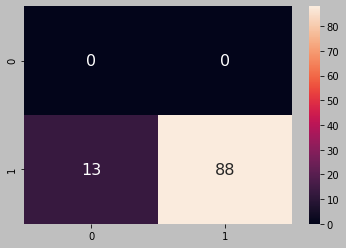

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

df_cm = confusion_matrix(sub_df['actual_cls'], sub_df['pred_cls'])
tn, fp, fn, tp = confusion_matrix(sub_df['actual_cls'], sub_df['pred_cls']).ravel()
print(f"Accuracy : {(tp+fp)/(tn+fp+fn+tp)*100}%")
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.show()

In [ ]:
sub_df['PredictionString'].head(10)

0        0.8395 581 357 198 353 0.8281 212 449 228 300
1    0.8187 714 591 138 124 0.7349 310 606 175 109 ...
2                                                     
3        0.9761 243 554 204 220 0.9587 652 463 191 308
4    0.8751 179 255 206 413 0.8741 598 246 174 431 ...
5                                                     
6        0.9354 209 457 218 226 0.7967 637 443 181 377
7        0.9733 676 400 203 309 0.9694 134 683 212 161
8        0.9730 602 201 218 448 0.9701 176 234 230 414
9    0.9680 257 303 177 287 0.8765 683 456 159 159 ...
Name: PredictionString, dtype: object

#### Save Model

In [ ]:
%%capture
torch.save(model.state_dict(), 'pytorch_model.pt')

model.load_state_dict(torch.load('/content/pytorch_model.pt'))
model.to(device)

In [ ]:
!mkdir test_pred

In [ ]:
ids = ['person77_bacteria_377.jpeg', 'person80_virus_150.jpeg']

detection_threshold = 0.1
img_num = 0
results = []

with torch.no_grad():
    for i, image_s in tqdm(enumerate(ids)):
        print(ids)
        orig_image = cv2.imread(f"/content/{ids[i]}", cv2.IMREAD_COLOR)
        
        image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image = np.transpose(image, (2, 0, 1)).astype(np.float)
        image = torch.tensor(image, dtype=torch.float).cuda()
        image = torch.unsqueeze(image, 0)

        model.eval()
        cpu_device = torch.device("cpu")

        outputs = model(image)
        
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        
        if len(outputs[0]['boxes']) != 0:
            for counter in range(len(outputs[0]['boxes'])):
                boxes = outputs[0]['boxes'].data.cpu().numpy()
                scores = outputs[0]['scores'].data.cpu().numpy()
                boxes = boxes[scores >= detection_threshold].astype(np.int32)
                draw_boxes = boxes.copy()
                boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
                
            for box in draw_boxes:
                img=cv2.rectangle(orig_image,
                            (int(box[0]), int(box[1])),
                            (int(box[2]), int(box[3])),
                            (0, 0, 255), 3)

            #print("**********start********")
            plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            
            plt.savefig(f"./test_pred/test{i}.jpg")
            plt.close()

            result = {
                'patientId': image_s,
                'PredictionString': format_prediction_string(boxes, scores),
                'pred_cls': 1 if len(draw_boxes) > 0 else 0,
                'actual_cls': 1,
            }
            results.append(result)
        else:
            result = {
                'patientId': image_s,
                'PredictionString': None,
                'pred_cls': 0,
                'actual_cls': 1,
            }
            results.append(result)

print(results)

0it [00:00, ?it/s]

['person77_bacteria_377.jpeg', 'person80_virus_150.jpeg']


1it [00:00,  2.89it/s]

['person77_bacteria_377.jpeg', 'person80_virus_150.jpeg']


2it [00:00,  2.98it/s]

[{'patientId': 'person77_bacteria_377.jpeg', 'PredictionString': '0.4844 162 465 207 145 0.2704 235 158 197 198 0.1568 735 490 192 157 0.1476 992 630 68 89 0.1136 181 77 256 331', 'pred_cls': 1, 'actual_cls': 1}, {'patientId': 'person80_virus_150.jpeg', 'PredictionString': '0.6766 797 272 160 130 0.6552 803 262 187 213 0.5060 273 395 195 180 0.3480 248 263 234 313 0.1994 773 229 242 425 0.1618 725 483 198 212 0.1301 275 153 241 165 0.1150 783 195 208 219 0.1129 928 629 101 89', 'pred_cls': 1, 'actual_cls': 1}]


Enter the path of your file: /content/test_pred/test0.jpg


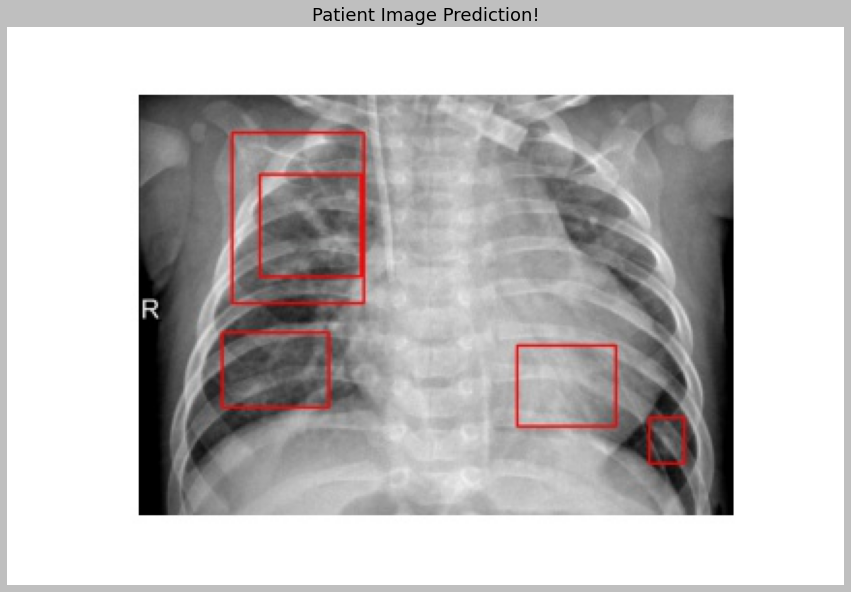

In [ ]:
def pred_image(img_path):
    orig_image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image = np.transpose(image, (2, 0, 1)).astype(np.float)
    image = torch.tensor(image, dtype=torch.float).cuda()
    image = torch.unsqueeze(image, 0)

    
    plt.figure(figsize=(15,12))
    plt.title("Patient Image Prediction!", fontsize=18)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))

# PREDICTION FOR TWO TEST IMAGES.
path = input("Enter the path of your file: ")
pred_image(str(path))

## The End